Let's add a little class to make producing XML (and therefor SVG) easy. Note that this originally targeted boost-histogram, so it's written in Python 2 compatible style and does not use any external libraries.

In [1]:
class XML(object):
    def __init__(self, *contents, **kargs):
        self.properties = kargs
        self.contents = contents

    @property
    def name(self):
        return self.__class__.__name__

    @property
    def start(self):
        if self.properties:
            ending = " " + " ".join(
                '{a}="{b}"'.format(a=a.replace("_", "-"), b=b)
                for a, b in self.properties.items()
            )
        else:
            ending = ""
        return self.name + ending

    def __str__(self):
        if self.contents:
            return "<{self.start}>\n{contents}\n</{self.name}>".format(
                self=self, contents="\n".join(str(s) for s in self.contents)
            )
        else:
            return "<{self.start}/>".format(self=self)

Now let's add classes that exactly correspond to the `XML` tags:

In [2]:
class svg(XML):
    def _repr_svg_(self):
        return str(self)


class circle(XML):
    pass


class line(XML):
    pass


class rect(XML):
    pass


class ellipse(XML):
    pass


class polygon(XML):
    pass


class polyline(XML):
    pass


# path
class text(XML):
    pass


class g(XML):
    pass

Now let's make sure these work as expected:

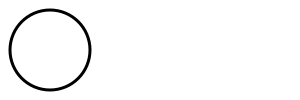

In [3]:
c1 = circle(cx=50, cy=50, r=40, stroke="black", stroke_width=3, fill="white")
s1 = svg(c1, height=100, width=300)
s1

In [4]:
print(s1)

<svg height="100" width="300">
<circle cx="50" cy="50" r="40" stroke="black" stroke-width="3" fill="white"/>
</svg>


In [5]:
import textwrap
import numpy as np
import boost_histogram as bh
import functools
import operator

In [31]:
class rect(XML):
    @classmethod
    def pad(cls, scale_x, scale_y, height, left_edge, right_edge, pad_x=0, pad_y=0, opacity=1):
        width = right_edge - left_edge
        center_y = height / 2.0
        top_y = 1 - height

        height = height * (1 - 2 * pad_y)
        top_y = top_y * (1 - 2 * pad_y) + pad_y
        left_edge = left_edge * (1 - 2 * pad_x) + pad_x
        width = width * (1 - 2 * pad_x)
        color = int(255 * opacity)

        return cls(
            x=left_edge * scale_x,
            y=top_y * scale_y,
            width=width * scale_x,
            height=height * scale_y,
            style=f"fill:white;stroke:rgb(255,255,255);stroke-width:1",
        )

Now let's make a svg plotting function:

This automatically but poorly scales if the axes is more than 40 bins wide. The issue is that it simply rebins, rather than making uneven width bins when necessary.

In [32]:
def plot_hist_1d(hi):
    assert hi.ndim == 1
    assert not hi.axes[0].options.circular

    if len(hi.axes[0]) > 40:
        h = hi[:: bh.rebin(len(hi.axes[0]) // 20)]
    else:
        h = hi

    (edges,) = h.axes.edges
    norm_edges = (edges - edges[0]) / (edges[-1] - edges[0])
    norm_vals = h.view()

    if not h.empty():
        norm_vals /= functools.reduce(operator.mul, h.axes.widths) / h.sum()
        norm_vals /= np.max(norm_vals)

    boxes = []
    for height, left_edge, right_edge in zip(
        norm_vals, norm_edges[:-1], norm_edges[1:]
    ):
        boxes.append(rect.pad(300, 100, height, left_edge, right_edge, 0.02, 0.05))

    # boxes.append(rect(x=0, y=0, width=600, height=120, style="fill:none;stroke-width:3;stroke:rgb(0,0,0)"))
    ax_line = line(
        x1=0,
        y1=100 * 0.95,
        x2=300,
        y2=100 * 0.95,
        style="fill:none;stroke-width:2;stroke:rgb(0,0,0)",
    )
    texts = [
        text(format(edges[0], ".3g"), x=10, y=110),
        text(format(edges[-1], ".3g"), x=300 - 20, y=110),
        text(
            "\n".join(textwrap.wrap(repr(hi), 38)),
            x=300,
            y=40,
            style="font-family: monospace",
        ),
    ]

    return svg(ax_line, *texts, *boxes, width=600, height=120)

And let's add it inline. (In an actual library, this should just have been a method, really)

In [33]:
class Histogram(bh.Histogram):
    def _repr_svg_(self):
        # This can be _repr_html_ instead, too - would make adding text easier/nicer
        if self.ndim == 1:
            return plot_hist_1d(self)._repr_svg_()
        elif self.ndim == 2:
            return plot_hist_2d(self)._repr_svg_()

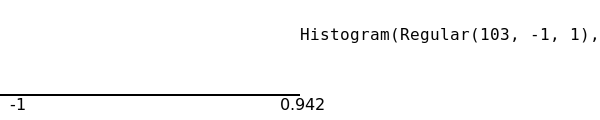

In [34]:
h = Histogram(bh.axis.Regular(103, -1, 1))
h

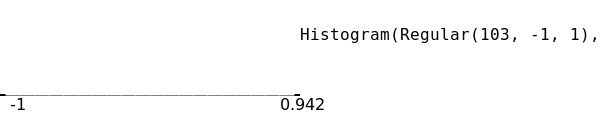

In [35]:
h.fill(np.random.normal(size=100_000))

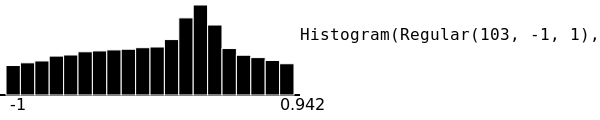

In [266]:
h.fill(np.random.normal(0.3, 0.1, size=10_000))

In [214]:
print(repr(h))

Histogram(Regular(103, -1, 1), storage=Double()) # Sum: 78071.0 (110000.0 with flow)


In [203]:
def plot_hist_2d(hi):
    assert hi.ndim == 2
    assert not hi.axes[0].options.circular
    assert not hi.axes[1].options.circular

    if len(hi.axes[0]) > 40:
        hi = hi[:: bh.rebin(len(hi.axes[0]) // 20), :]
    
    if len(hi.axes[1]) > 40:
        hi = hi[:, :: bh.rebin(len(hi.axes[1]) // 20)]
    
    h = hi

    edges = (h.axes[0].edges, h.axes[1].edges)
    norm_edges = ((edges[0] - edges[0][0]) / (edges[0][-1] - edges[0][0]), 
                  (edges[1] - edges[1][0]) / (edges[1][-1] - edges[1][0]))
    
    norm_vals = h.view()
    if not h.empty():
        norm_vals /= functools.reduce(operator.mul, h.axes.widths) / h.sum()
        norm_vals /= np.max(norm_vals)

    boxes = []
    for opacity, left_edge, right_edge in zip(
        norm_vals, norm_edges[0][:-1], norm_edges[0][1:]
    ):
        boxes.append(rect.pad(350, 350, 1, left_edge, right_edge, 0.05, 0.05))
        
    for opacity, left_edge, right_edge in zip(
        norm_vals, norm_edges[1][:-1], norm_edges[1][1:]
    ):
        boxes.append(rect.pad(350, 350, right_edge, 0, 1, 0.05, 0.05, opacity=opacity))
            
    texts = [
        text(format(edges[0][0], ".3g"), x=-10, y=30),
        text(format(edges[0][-1], ".3g"), x=350-10, y=30),
        text(
            "\n".join(textwrap.wrap(repr(hi), 38)),
            x=300,
            y=40,
            style="font-family: monospace",
        ),
    ]

    return svg(*texts, *boxes, width=400, height=400)

In [204]:
h = Histogram(bh.axis.Regular(103, -1, 1), bh.axis.Regular(103, -2, 2)).fill([.1, .1], [.1, .2])
h